# Import libraries

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

import numpy as np

# Trajectories modeled as neural networks

In [ ]:
# Design the neural network

# Define a function to create a neural network model for trajectory prediction
def createTraj():
    # Create a Sequential model
    fhat = Sequential()

    # Add a densely connected layer with 50 neurons, using sigmoid activation function, and expecting input dimension of 1
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))

    # Add a densely connected layer with 1 neuron
    fhat.add(Dense(1, activation=None))

    # Return the created model
    return fhat

In [ ]:
def createTrajControl(output_activation):
    # Create a Sequential model
    fhat = Sequential()

    # Add a densely connected layer with 50 neurons, using sigmoid activation function, and expecting input dimension of 1
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))

    # Add a densely connected layer with the appropriate activation function for output
    fhat.add(Dense(1, activation=output_activation))

    # Return the created model
    return fhat

# Create separate instances of the neural network model for the control variables
# Each instance will have its own set of weights and biases
f = createTrajControl(output_activation='sigmoid')  # Model for T, with output bounded between [0, 1]
mom = createTrajControl(output_activation='tanh')     # Model for M, with output bounded between [-1, 1]

# Create separate instances of the neural network model for different aspects of trajectory prediction
# Each instance will have its own set of weights and biases
x = createTraj()  # Model for X trajectory
y = createTraj()  # Model for Y trajectory
#v = createTraj()  # Model for velocity
#th = createTraj() # Model for steering angle

print("Summary of model for x trajectory:")
x.summary()
print()
print("Summary of model for y trajectory:")
y.summary()
print()

print("Summary of model for thrust trajectory:")
f.summary()
print()
print("Summary of model for moment trajectory:")
mom.summary()
print()

'''
print("Summary of model for v trajectory:")
v.summary()
print()
th.summary()
'''

Summary of model for x trajectory:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                100       
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Summary of model for y trajectory:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                100       
                                                                 
 dense_7 (Dense)             (None, 1)                 

'\nprint("Summary of model for v trajectory:")\nv.summary()\nprint()\nth.summary()\n'

# Compute loss function

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Constants
m = 1
I = 1

# Define your obstacles here (center_x, center_y, radius)
obstacles = [(0.4, 0.4, 0.05), (0.70, 0.70, 0.05)]

def obstacle_penalty(X, Y, obstacles, penalty_scale):
    penalty = 0
    for center_x, center_y, radius in obstacles:
        distance_to_obstacle = tf.sqrt((X - center_x)**2 + (Y - center_y)**2)
        penalty += tf.where(distance_to_obstacle < radius, penalty_scale * (radius - distance_to_obstacle)**2, 0.0)
    return tf.reduce_sum(penalty)

# Generate a time array T from T0 to Tf with nPts points
T0, Tf, nPts = 0, 10, 10
T = tf.cast(tf.linspace(T0, Tf, nPts), dtype=tf.float32)

def errors(t, m=m, I=I, obstacles=obstacles):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(t)
            # Compute the trajectories X and Y at time t using neural network models
            X = x(t)  # Output from neural network for X
            Y = y(t)  # Output from neural network for Y
        # Compute the first derivatives of X and Y with respect to time
        Xd = tape1.gradient(X, t)  # Velocity in X
        Yd = tape1.gradient(Y, t)  # Velocity in Y
    # Compute the second derivatives of X and Y with respect to time
    Xdd = tape2.gradient(Xd, t)  # Acceleration in X
    Ydd = tape2.gradient(Yd, t)  # Acceleration in Y

    # Get the thrust and moment from neural network output
    thrust = f(t)  # Thrust from the neural network
    moment = mom(t)  # Moment from the neural network

    # Calculate errors in trajectory dynamics based on the EOMs
    e_xddot = (m * Xdd - thrust * tf.cos(Y)) ** 2
    e_yddot = (m * Ydd - thrust * tf.sin(Y)) ** 2
    e_thddot = (I * Ydd - moment) ** 2

    # Calculate errors in initial and final conditions
    x0, y0, xf, yf = 0, 0, 1, 1
    eIC = (X[0] - x0)**2 + (Y[0] - y0)**2 + Xd[0]**2 + Yd[0]**2
    eFC = (X[-1] - xf)**2 + (Y[-1] - yf)**2 + Xd[-1]**2 + Yd[-1]**2

    # Calculate the obstacle avoidance penalty
    obstacle_loss = obstacle_penalty(X, Y, obstacles, penalty_scale=10.0)

    # Combine all errors into a total error
    total_error = e_xddot + e_yddot + e_thddot + 50 * eIC + 50 * eFC + 250 * obstacle_loss
    #return total_error
    # Return both the total error and the individual error components
    return total_error, e_xddot, e_yddot, e_thddot, eIC, eFC, obstacle_loss


# Train the network

In [ ]:
nIter = 1001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

for i in range(nIter):
    with tf.GradientTape() as tape:
        e = errors(T)
    grads = tape.gradient(e, x.trainable_variables + y.trainable_variables + f.trainable_variables + mom.trainable_variables)
    optimizer.apply_gradients(zip(grads, x.trainable_variables + y.trainable_variables + f.trainable_variables + mom.trainable_variables))
    if i % 50 == 0:
        print(f'iter: {i}, error: {e}')


iter: 0, error: (<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 , 1.0738832 , 1.0468243 ],
       [0.534814  , 0.54791784, 0.9320572 , 0.8721428 , 0.94830483,
        1.1567119 , 1.2118851 , 1.1339132 ,

# Plot the results

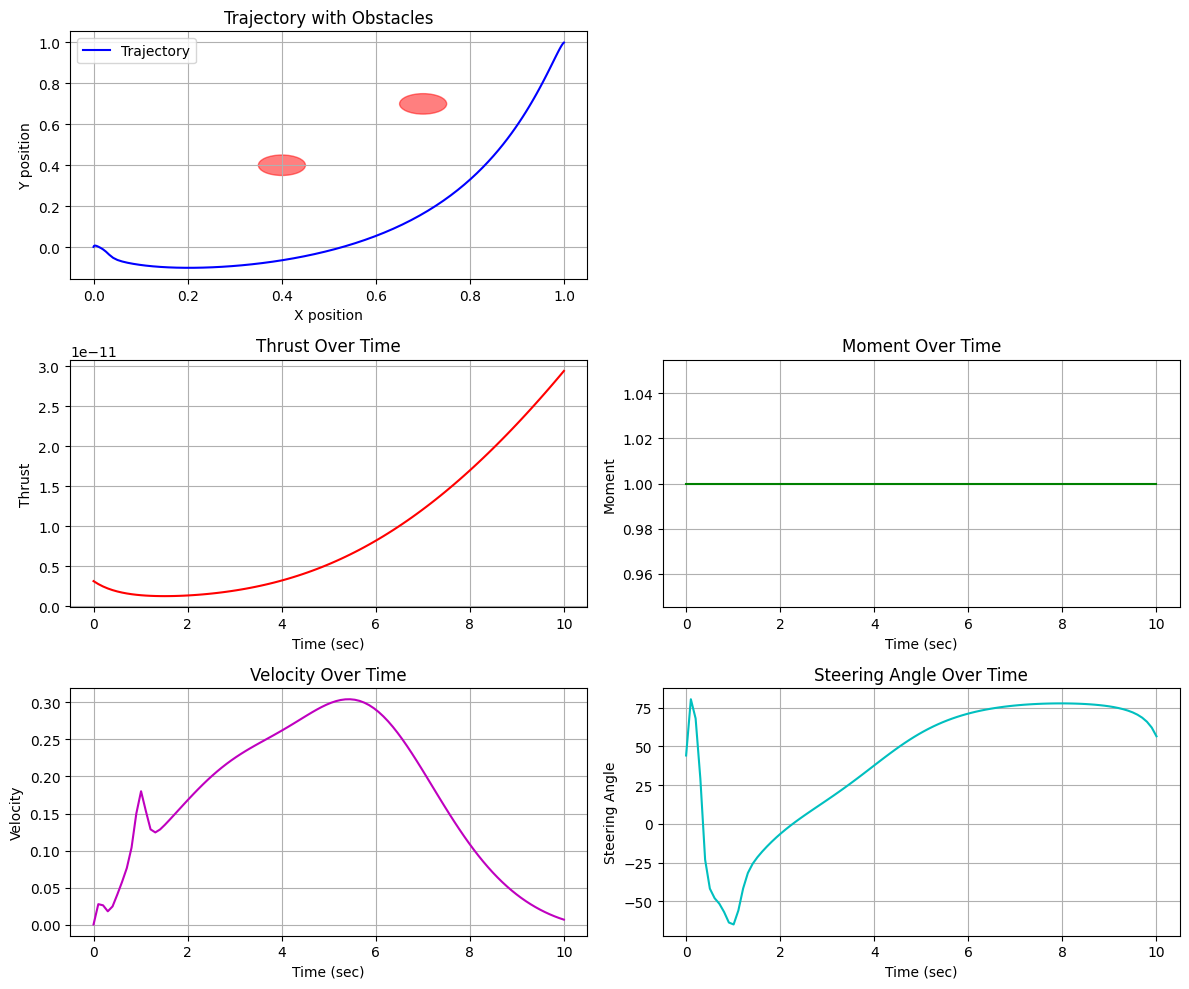

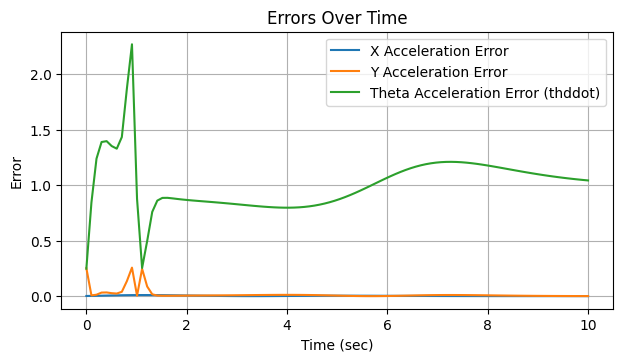

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.patches as patches

# Assume Tf, nPts1, x, y, f, mom, obstacles, and errors are already defined

nPts1 = 100
# Calculate time points
TT = tf.cast(tf.linspace(0, Tf, nPts1), dtype=tf.float32)
tt = TT.numpy()

# Initialize plotting
plt.figure(figsize=(12, 10))

with tf.GradientTape(persistent=True) as tape:
    tape.watch(TT)
    X = x(TT)  # Position X
    Y = y(TT)  # Position Y
    thrust = f(TT)  # Thrust
    moment = mom(TT)  # Moment

# Compute the derivatives (velocities) as required
Xd = tape.gradient(X, TT)  # Velocity in X
Yd = tape.gradient(Y, TT)  # Velocity in Y

# Calculate V and Theta
V = tf.sqrt(Xd**2 + Yd**2)  # Velocity magnitude
Theta = tf.atan2(Yd, Xd)  # Steering angle

# Calculate the errors using the errors function
# This function must be defined and should return error values.
# total_error, e_xddot, e_yddot = errors(TT, ...)
# Ensure that the errors function returns values that can be plotted, such as scalars for each time point

# Trajectory and Obstacles Plot
plt.subplot(3, 2, 1)
plt.plot(X.numpy(), Y.numpy(), 'b', label='Trajectory')
# Visualize obstacles
for obstacle in obstacles:
    circle = patches.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', alpha=0.5)
    plt.gca().add_patch(circle)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Trajectory with Obstacles')
plt.legend()
plt.grid(True)

# Thrust Plot
plt.subplot(3, 2, 3)
plt.plot(tt, thrust.numpy(), 'r')
plt.xlabel('Time (sec)')
plt.ylabel('Thrust')
plt.title('Thrust Over Time')
plt.grid(True)

# Moment Plot
plt.subplot(3, 2, 4)
plt.plot(tt, moment.numpy(), 'g')
plt.xlabel('Time (sec)')
plt.ylabel('Moment')
plt.title('Moment Over Time')
plt.grid(True)

# Velocity Plot
plt.subplot(3, 2, 5)
plt.plot(tt, V.numpy(), 'm')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity')
plt.title('Velocity Over Time')
plt.grid(True)

# Assuming Theta is your steering angle in radians calculated previously
Theta_deg = Theta * (180 / np.pi)  # Convert to degrees manually

# Steering Angle Plot
plt.subplot(3, 2, 6)
plt.plot(tt, Theta_deg.numpy(), 'c')
plt.xlabel('Time (sec)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

# Assuming e_xddot, e_yddot, e_thddot are tensors with the error values for each time point
e_xddot_values = e_xddot.numpy().flatten()[:len(tt)]
e_yddot_values = e_yddot.numpy().flatten()[:len(tt)]
e_thddot_values = e_thddot.numpy().flatten()[:len(tt)]

# Now you can plot
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 2)
plt.plot(tt, e_xddot_values, label='X Acceleration Error')
plt.plot(tt, e_yddot_values, label='Y Acceleration Error')
plt.plot(tt, e_thddot_values, label='Theta Acceleration Error (thddot)')
plt.xlabel('Time (sec)')
plt.ylabel('Error')
plt.title('Errors Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
